## Objective of this Assignment

The goal of this assignment is to learn two, very important topics in deep learning.

* Data Invariance and Building Robust Models
* Transfer Learning

## Data Invariance and Building Robust Models

In this part of the assignment you will learn about Data Invariance and  model prediction with a simple example of MNIST dataset. 

Let's start with a simple example to understand what invariance is. As a human, we are invariant to read a sentence when it is writen in a different angle, orientation, if the sentense is flipped in an unusual direction, or even if the image is blurred (Augmentated) to some scale. But this is not the case for machine learning. If a machine learning model is not trained with augmentated data, the model won't be data invariant and will fail miserably in some cases.

So, to put it formally, Invariance to a transformation group(Image Augmentation) in Neural Networks can simply be defined as invariance(not-changing) of Neural Networks output with respect to this group acting on the input.

Many real world data analysis problems exhibit invariant structure, and models that take advantage of this structure have shown impressive empirical performance, particularly in deep learning. In this assignment, we analyze the benefits of data augmentation as a technique to make the model invariant to different input images.

Please read the following articles for a more deeper understanding [Article](https://towardsdatascience.com/invariance-causality-and-robust-deeplearning-df8db9091627) and
[Paper](https://arxiv.org/pdf/2005.00178.pdf)


In [ ]:
# Let's start with importing some necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


## Dataset Loading

In this section we will load the MNIST dataset with **80:10:10** training, test and validation split and visualize the dataset. You can change the split ratio differently if you want. Smaller size of training data will normally lead to a bad training model with relatively lower accuracy. Running the following cell will yield the number of classes and you can see a sample dataset from MNIST.


10
Number of classes we want to classify 10
48000
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

<class 'tensorflow.python.framework.ops.EagerTensor'>


'\nfor train in train_ds:\n    X, y = train\n    # variable train is a tuple\n    # X is the image and y is the label\n    # write your stuffs here\n\n'

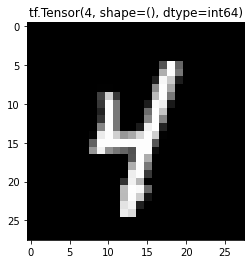

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'mnist',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

#print(train_ds.shape)
num_classes = metadata.features['label'].num_classes
print(num_classes)
print("Number of classes we want to classify", num_classes)
get_label_name = metadata.features['label'].int2str
print(len(train_ds))

print(metadata)
# Get a sample image and label
get_label_name = metadata.features['label'].int2str


image, label = next(iter(train_ds))
print(type(image))
image_show = np.squeeze(image)
plt.imshow(image_show, cmap='gray')
plt.title(get_label_name(label))



# You can iterate over the whole trainig set in the following way as well
# Remove the quotes from the following section to iterate over the train_ds
# and play with the dataset
"""
for train in train_ds:
    X, y = train
    # variable train is a tuple
    # X is the image and y is the label
    # write your stuffs here

"""

## Data Scaling and Rotation

Out of sample image means, it is highly different from the original training set. The distribution of out-of-sample data can be different, or they may have a different orientation, flip, brighhtness. Now we will see some examples of how we can rescale, flip and rotate an image. In tensorflow we can create a Sequential Layer with these functionalities and the rest will be taken care automatically by TensorFlow.

There are a variety of preprocessing layers you can use for data augmentation including *tf.keras.layers.RandomContrast*, *tf.keras.layers.RandomCrop*, *tf.keras.layers.RandomZoom*, and others.

In the following example, we will write a Sequential layer where we will resize and rescale an image and see the output.

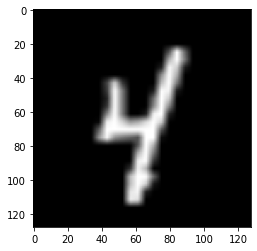

In [ ]:
# Rescaling the Image
IMG_SIZE = 128
resize_and_rescale = tf.keras.Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE),layers.Rescaling(1./255)])

# Resccaling will not change how the image looks. It only divides the pixel values by 255.
# So all the pixel values are between 0 and 1
result = resize_and_rescale(image, label)

plt.imshow(np.squeeze(result), cmap='gray')

Now we are going to create another Sequential Layer to Flip and randomly rotate 50% of the images and see how the rotation/flip looks like. Run the following cell and see the output. We will put the same image in our *data_augmentation* sequential layer. You will see that, the images are still recognizable by a human eye. We can safely say that the number in the images are 4. But if we don't use these rotated images in our training dataset, the model will have a very hard time prediccting the correct output.


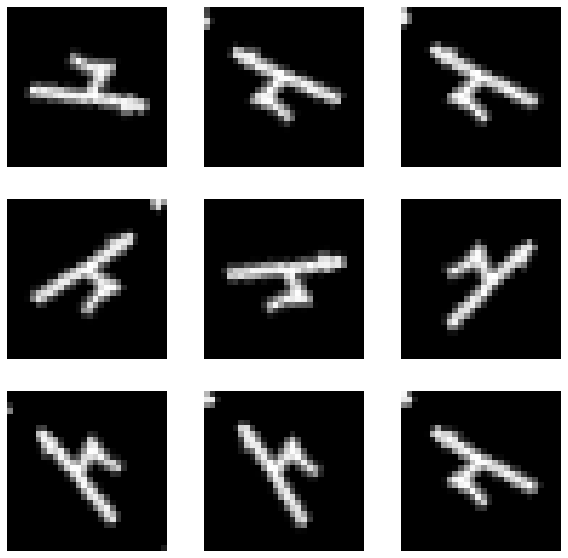

In [ ]:
data_flip_and_rotation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_flip_and_rotation(tf.expand_dims(image, 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(augmented_image[0]), cmap='gray')
    plt.axis("off")

Now we are going to write a function called *data_augment* that will resize, rescale, shuffle and flip and rotate the images based on 2 paremeters,  and create batches of data. Default batch size is 32.

In [ ]:
#batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def data_augment(ds, shuffle=False, augment=False, batch_size=32):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                  num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_flip_and_rotation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


The following section is very important. In this section we will create train, test and validation data with batch size 32. See line 1 and 4 of the following cell. In line 1, we are creating training data without any shhuffling and augmentation. If we use this as our training data for the model, and test with out-of-sample test data, we will have a very bad result. But we can improve the result if we can also train our model with augmented images.

In [ ]:
final_train_ds = data_augment(train_ds, shuffle=False, augment=False)
final_test_ds = data_augment(test_ds, shuffle=False, augment=False)

## Create a CNN model with at-least 1 dense layer

In [ ]:
# Question 1: Create a CNN model with at least 1 Dense Layer. (1 Point)

#Write your code here
'''
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  #data_augment,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  # Rest of your model.
])
'''

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
'''

model = Sequential()

#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
#model.add(Dense(1, activation='softmax'))
#model.add(Dense(1, activation='softmax'))
#model.add(Dense(1, activation='softmax'))
#model.add(Dense(1, activation='softmax'))
model.add(Flatten())

model.summary()
print(len(final_train_ds))
'''

print("Something")


Something


## Compile your Model

In [ ]:
# Question 2: Compile the model. Since this is a multi class classification, put appropriate loss function. (1 Point)

#Write your code here

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(len(final_train_ds))
#print(final_train_ds.shape)
#final_train_ds = np.asarray(final_train_ds).astype('float32').reshape((-1,1))

print(len(final_test_ds))

1500
188


## Training the model and evaluate model with normal test data. 

From the output we can see that we have created a very accurate model. In this case the accuracy is over 98%. Now the model is ready to be shipped to a real life use case. So now we are going to save the model and then load the model similar to a real life scenario.

In [ ]:
epochs=3
history = model.fit(
  final_train_ds,
  epochs=epochs
)

loss, acc = model.evaluate(final_test_ds)
print("Accuracy", acc)

# Save the model
model.save('epic_num_classification.model')

Epoch 1/3
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2332 - accuracy: 0.9373
Epoch 2/3
1500/1500 [==============================] - 31s 20ms/step - loss: 0.0542 - accuracy: 0.9831
Epoch 3/3
188/188 [==============================] - 2s 9ms/step - loss: 0.0665 - accuracy: 0.9813
Accuracy 0.981333315372467
INFO:tensorflow:Assets written to: epic_num_classification.model/assets


INFO:tensorflow:Assets written to: epic_num_classification.model/assets


## Use real samples "out-of-distribution" data for prediction

Now our model is shipped to the user. So from the users perpective, the user will use the model and try the model with different random images of numbers.
We will put some images through the models and see the prediction.

**Notice the difference in accuraccy?**

The accuracy is very low. Now we are going to put some of the images from our real life data and see what is the real output and what the model predicts. In this case, real life data means, the data, which the model has never seen during training or testing.

See the predicted label and the actual to determine how many images were incorrectly predicted. You can clearly see that there are lots of incorrect predictions.

188/188 [==============================] - 6s 28ms/step - loss: 7.5602 - accuracy: 0.3263
Accuracy 0.32633334398269653


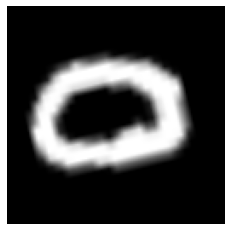

Prediction scores from the output layer(Without SoftMax):  [[10.741708  -5.503312   4.895015   1.2477801  0.3557728  2.4014382
   3.1111236  7.3324876 -3.6256402  8.220553 ]]
Predicted label: 0


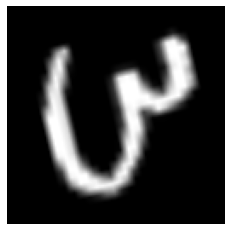

Prediction scores from the output layer(Without SoftMax):  [[15.307209   4.6207333 -9.9074     0.9876656  6.0993547  3.1128066
  10.779694  -0.8583841 10.84525   -2.2812924]]
Predicted label: 0


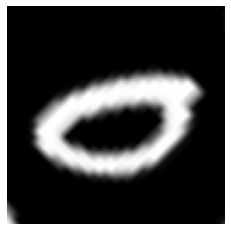

Prediction scores from the output layer(Without SoftMax):  [[15.733686   -1.3799894   1.9587768   4.415029   -0.513807    6.6133165
   6.7555532   5.0039225   0.23193152  1.4816624 ]]
Predicted label: 0


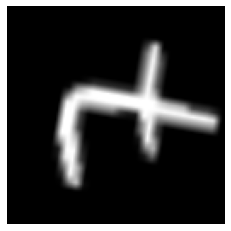

Prediction scores from the output layer(Without SoftMax):  [[ 8.602767   -0.13153937  8.042245    1.0406232   8.119534    5.126126
   8.855152   -2.168163    8.141237   -0.09207307]]
Predicted label: 6


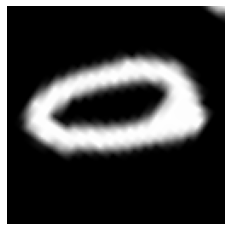

Prediction scores from the output layer(Without SoftMax):  [[ 3.6884372  -4.5310073  12.96303     3.6529322   0.38434798  7.723007
   0.5283631   6.4502263   7.567885    9.75993   ]]
Predicted label: 2


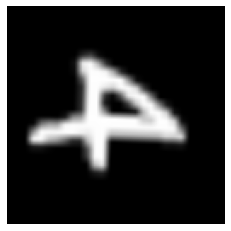

Prediction scores from the output layer(Without SoftMax):  [[ 4.6944513 -3.190156  11.685622  -0.7344875  4.404614   9.077319
   5.313893   7.505142   5.987913  -3.9738495]]
Predicted label: 2


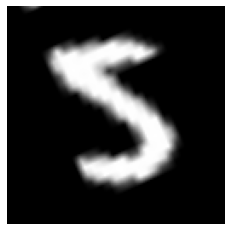

Prediction scores from the output layer(Without SoftMax):  [[-0.37360248  2.5698721   3.3239589  14.968745   -3.023818   15.867866
   3.2420688   3.5179508  11.662892    4.2004733 ]]
Predicted label: 5


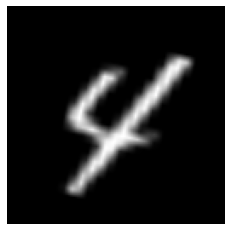

Prediction scores from the output layer(Without SoftMax):  [[ 0.19304235  6.3647366   5.2833843   1.982839   13.779264    0.9489818
  -0.68762183  2.0554276   8.914895    2.0698168 ]]
Predicted label: 4


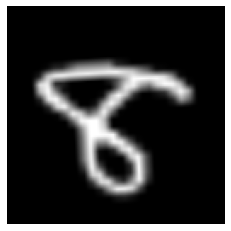

Prediction scores from the output layer(Without SoftMax):  [[ 5.3661075  1.0013382  5.5051594  9.22802   -5.2003193 12.862407
   1.6392621  6.3996987 18.773796   4.2179465]]
Predicted label: 8


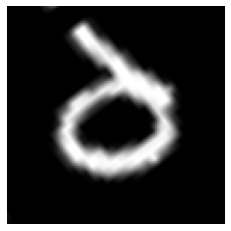

Prediction scores from the output layer(Without SoftMax):  [[20.358227  -2.2345269 12.726761   8.754125   2.3277166  3.2491767
   4.3221726  1.9646772 -1.2009217  3.4082105]]
Predicted label: 0


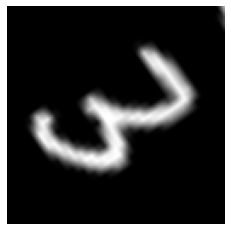

Prediction scores from the output layer(Without SoftMax):  [[ 8.762477  -4.538316   2.3860867  8.805061   0.5291515 12.587432
   9.545467  -6.088736  13.418694   5.193926 ]]
Predicted label: 8


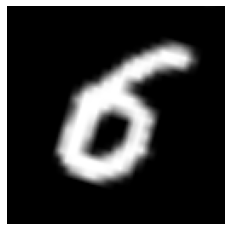

Prediction scores from the output layer(Without SoftMax):  [[11.255731   -3.8927376  -4.3106456   0.98445505 -2.565678   12.1192665
  20.302782   -5.5249543  11.632271    2.8622816 ]]
Predicted label: 6


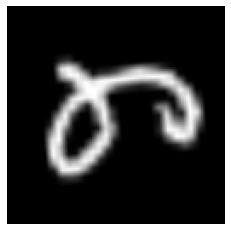

Prediction scores from the output layer(Without SoftMax):  [[15.160065    0.31303355  6.011334   -3.4694436  -1.8903484   8.979238
   7.918742   10.383326    9.113651    1.5239115 ]]
Predicted label: 0


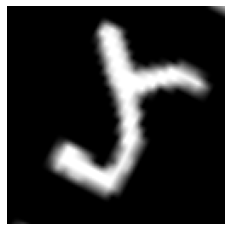

Prediction scores from the output layer(Without SoftMax):  [[ 5.8562913 11.349965  -1.4400204 11.700758  -3.5576732 21.7229
   7.471395   6.27411   10.853888  -1.7171147]]
Predicted label: 5


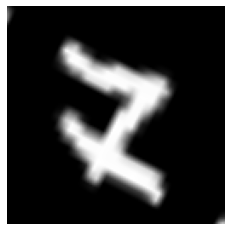

Prediction scores from the output layer(Without SoftMax):  [[-0.5313713   4.324648   12.717002   12.326714    0.38576573  4.431526
  -7.848805    9.142612    7.978824    4.7916703 ]]
Predicted label: 2


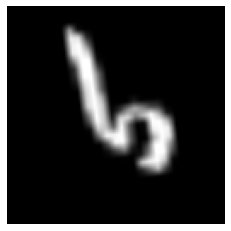

Prediction scores from the output layer(Without SoftMax):  [[-1.7523222   4.200885    3.759997    4.149067    7.648686    5.641841
  14.296058   -0.24671191  6.394824   -9.543975  ]]
Predicted label: 6


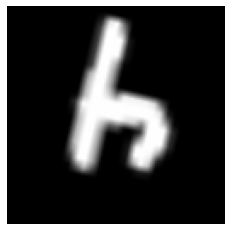

Prediction scores from the output layer(Without SoftMax):  [[ 0.34170648  3.8285563   2.2144957  -2.002974   10.400866    6.0267496
  17.251762   -2.8574321   4.475393   -5.5175896 ]]
Predicted label: 6


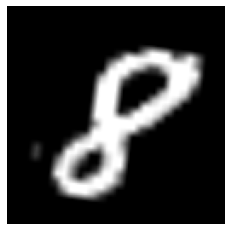

Prediction scores from the output layer(Without SoftMax):  [[ 7.9050846  3.324496  10.821079   8.506885   4.7619643  7.501211
   2.3498366  2.046599  28.904213   2.0250573]]
Predicted label: 8


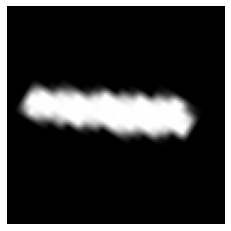

Prediction scores from the output layer(Without SoftMax):  [[-0.4420528   0.17253801  5.108124   -0.17059368  9.725438    6.9801817
   5.7396483  21.026295    0.6605033  -3.955778  ]]
Predicted label: 7


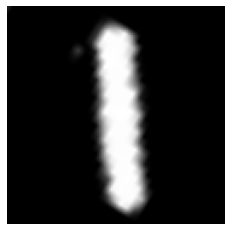

Prediction scores from the output layer(Without SoftMax):  [[-5.3659987 15.179093   2.6434155  2.0110433  6.625856   5.0299096
   3.8870409  5.9859195  4.5888166  2.2867107]]
Predicted label: 1


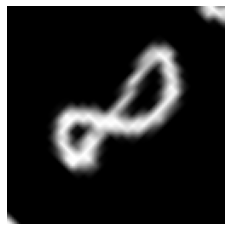

Prediction scores from the output layer(Without SoftMax):  [[ 2.6737068  6.657629   7.203563  -1.0719588  9.971904  -5.893963
   7.0460696 -3.0296264  9.575765   3.2235315]]
Predicted label: 4


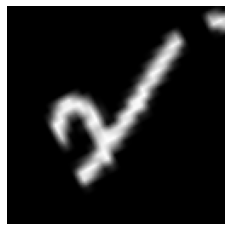

Prediction scores from the output layer(Without SoftMax):  [[-0.72930557 13.247976   -0.69208944 -8.986719   13.634979    3.1850476
   7.89825     2.5852609   8.230633   -2.9280279 ]]
Predicted label: 4


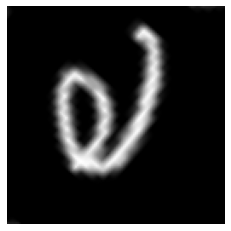

Prediction scores from the output layer(Without SoftMax):  [[13.3313465  3.4030092 -2.229732  -1.1003078  5.761537   4.3763866
   7.035597   5.1286182 10.167651   1.1332906]]
Predicted label: 0


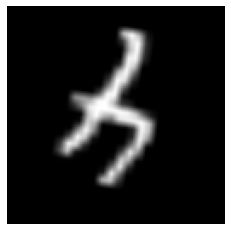

Prediction scores from the output layer(Without SoftMax):  [[ 1.6177304   1.2642183  -1.2350545   8.734657    8.440009   11.161019
  13.093207    1.5098568   5.8814      0.08433117]]
Predicted label: 6


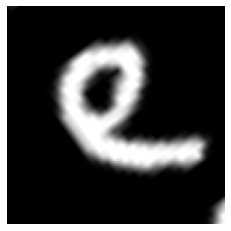

Prediction scores from the output layer(Without SoftMax):  [[ 1.691516    6.63849    12.188498   -1.128922    3.3489015  -0.20476586
   6.9182944   0.16185474  5.803586    2.2309453 ]]
Predicted label: 2


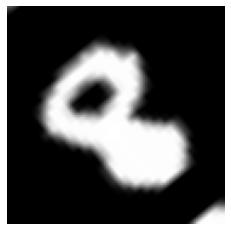

Prediction scores from the output layer(Without SoftMax):  [[-0.60744494  0.89997506  3.260438    4.55137     1.745618    2.1963367
   1.3744857   4.285192   10.620318    6.9603143 ]]
Predicted label: 8


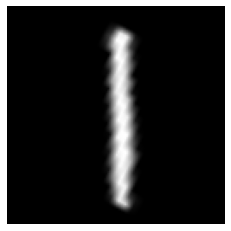

Prediction scores from the output layer(Without SoftMax):  [[-3.640862  17.443865  -3.6882868  3.4727852  6.2931876  8.118738
   3.216172   8.902564   4.6181974  0.7662662]]
Predicted label: 1


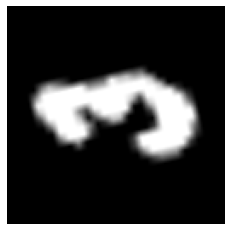

Prediction scores from the output layer(Without SoftMax):  [[10.41224    -3.6750252  -0.33418736 -5.530667    3.4709435   4.6640124
   4.610467   15.748161   -5.346298    7.793218  ]]
Predicted label: 7


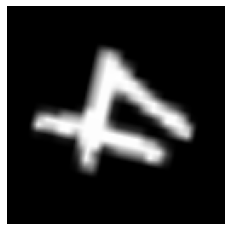

Prediction scores from the output layer(Without SoftMax):  [[12.302689   -0.10964658 11.802763   -2.5430236   9.427303    9.373309
   8.057147    3.3087661   0.45278215 -4.5091186 ]]
Predicted label: 0


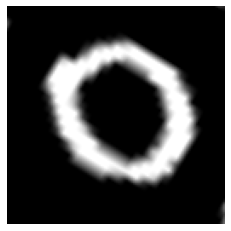

Prediction scores from the output layer(Without SoftMax):  [[21.163166   -4.4471383   4.9822125  -2.3900669   0.38319284  1.153537
   6.9458137  -1.6554531   7.0032      7.178679  ]]
Predicted label: 0


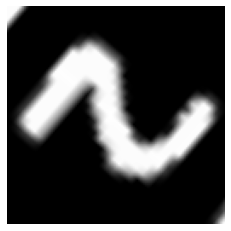

Prediction scores from the output layer(Without SoftMax):  [[ 6.551992    9.365975    8.648048   -0.07752509  4.4185476   3.7192943
   8.038431    6.635999    1.1683642  -2.88313   ]]
Predicted label: 1


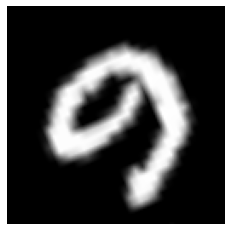

Prediction scores from the output layer(Without SoftMax):  [[ 8.372997  -1.4571221  6.231234   1.9832149  1.1805444  2.0514953
   1.1077741  5.2603416  7.731223  13.160627 ]]
Predicted label: 9


In [ ]:
real_life_data = data_augment(val_ds, shuffle=True, augment=True, batch_size=6)
#real_life_data1 = data_augment(test_ds, shuffle=True, augment=True, batch_size=6)

# Question 3:  Load the model that we saved in the previous cell. (1 Point)
# Write your code here

model.load_weights('epic_num_classification.model')

# Loss and Accuracy
loss, acc = model.evaluate(real_life_data)
print("Accuracy", acc)


X, y = next(iter(real_life_data))
def show_image_prediction(X, y):
    
    for i in  range(len(X)):
        image = X[i]
        label = y[i]
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.axis('off')
        plt.show()
        
        # Expand the validation image to (1, 128, 128, 3) before predicting the label
        prediction_scores = model.predict(np.expand_dims(image, axis=0))
        
        # The prediction scores are the output form the last layer
        print("Prediction scores from the output layer(Without SoftMax): ", prediction_scores)

        # Then we do an argmax over that list to find the one wiht the highest value and get the index 
        predicted_index = np.argmax(prediction_scores)
        #print(predicted_index)

        # Finally we use the get_label_name function to convert the integer index value into a string predicted label
        print("Predicted label: " + get_label_name(predicted_index))

show_image_prediction(X, y)

## **How to address this issue? or in another word, make sure CNN is rotation and scale invariant ?**
### Now we will create augmented training data by calling the **data_augment** fucntion we defined

#### Test and evaluate the model with out-of-sample dataset

Now you will be able to see that the accuracy of the model is restored and it is over 90%

In [ ]:
augmented_train_ds = data_augment(train_ds, shuffle=True, augment=True)

epochs=3
history = model.fit(
  augmented_train_ds,
  epochs=epochs
)

Epoch 1/3
1500/1500 [==============================] - 52s 34ms/step - loss: 0.6599 - accuracy: 0.7875
Epoch 2/3
1500/1500 [==============================] - 51s 34ms/step - loss: 0.3504 - accuracy: 0.8879
Epoch 3/3
1500/1500 [==============================] - 51s 34ms/step - loss: 0.2831 - accuracy: 0.9091


## Now again we will evaluate and predict image using our old, real life data. 

See how the accuracy improves and see the real examples of images along with their prediction.

188/188 [==============================] - 5s 27ms/step - loss: 0.2603 - accuracy: 0.9192
Accuracy 0.9191666841506958


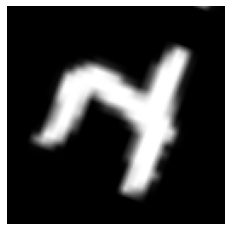

Prediction scores from the output layer(Without SoftMax):  [[-9.677116    3.3734074   7.234249    1.9567069  10.604612   -0.09058058
  -1.520481    5.396435    4.6822753   0.42526847]]
Predicted label: 4


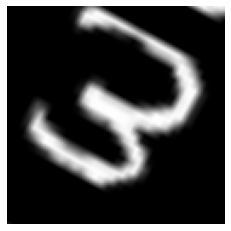

Prediction scores from the output layer(Without SoftMax):  [[-5.900805  -9.0251255  3.0180173 20.27052   -9.685893   4.7397556
   5.4739804 -3.4397829  5.0899725  1.6518662]]
Predicted label: 3


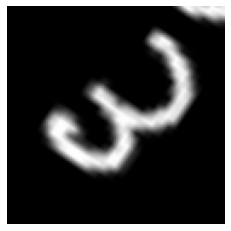

Prediction scores from the output layer(Without SoftMax):  [[-5.28247   -6.505269   4.018047  13.701674  -5.0602136  5.007167
   1.5744969 -1.3521469  4.1864963  4.161519 ]]
Predicted label: 3


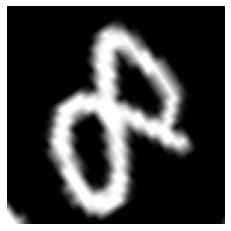

Prediction scores from the output layer(Without SoftMax):  [[-4.102013   -3.9894156   9.240839    6.2632356   2.8625522   3.617608
   5.9174533  -0.42091507 17.57109     5.1421227 ]]
Predicted label: 8


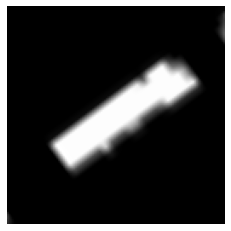

Prediction scores from the output layer(Without SoftMax):  [[-8.857407   10.749212    0.10349921 -3.6236227   2.3722944  -3.976802
  -1.1939882   2.9006972   1.5453625  -2.9918897 ]]
Predicted label: 1


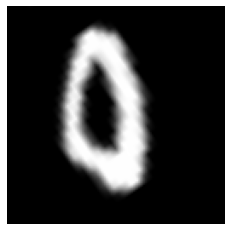

Prediction scores from the output layer(Without SoftMax):  [[ 8.632904   -5.8487725   2.2444792  -0.77814513 -4.7640758  -0.94567466
   4.930504   -0.36856478  2.6508706   6.499561  ]]
Predicted label: 0


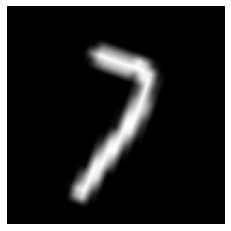

Prediction scores from the output layer(Without SoftMax):  [[-1.4148993   4.104205    2.0331974  -1.4119918   1.9484574   0.01427623
   2.5901716   9.376485   -0.75226414  1.7540967 ]]
Predicted label: 7


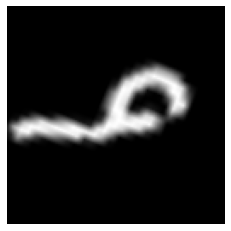

Prediction scores from the output layer(Without SoftMax):  [[-8.686531   -6.964659    3.4403386  -0.03637975  0.93454665  6.021546
   1.7259725  -1.451413   -0.16524178  4.942563  ]]
Predicted label: 5


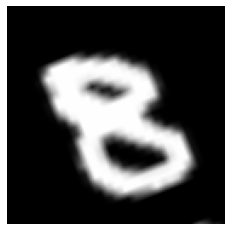

Prediction scores from the output layer(Without SoftMax):  [[ 1.5906304 -9.110206   3.9648247  1.8760239  0.5059722  1.8239073
   4.534929  -3.8558562 12.066349   5.70721  ]]
Predicted label: 8


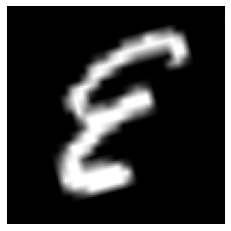

Prediction scores from the output layer(Without SoftMax):  [[-0.3445644  -0.40234733  4.453359   15.800838   -1.7968717   5.9593606
   1.3827363   4.5723324   0.12834579  1.7566779 ]]
Predicted label: 3


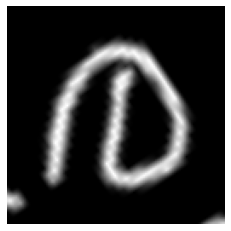

Prediction scores from the output layer(Without SoftMax):  [[ 2.5531633  -7.3627167   3.563937    2.7733836  -5.6207633   3.934985
  11.533633   -1.5520444   0.30879194  7.0282145 ]]
Predicted label: 6


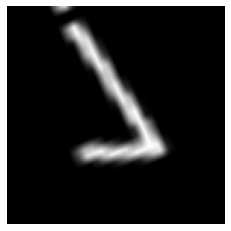

Prediction scores from the output layer(Without SoftMax):  [[-8.7039795  -1.020338    2.256277    0.02293211 -1.5305067   0.6721374
   2.6344066   7.6426883  -1.8115952   1.8114977 ]]
Predicted label: 7


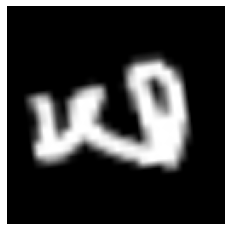

Prediction scores from the output layer(Without SoftMax):  [[-8.420116  -4.4455104  3.866419   5.184686  -2.5553157  2.3648372
   3.7363913 -1.2305386  3.8572924  0.6006439]]
Predicted label: 3


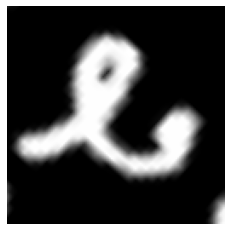

Prediction scores from the output layer(Without SoftMax):  [[-6.1601515 -4.1997514  9.914952   0.6592322  2.4755278  4.7045755
   1.0975432  5.123531   2.2219422  2.608987 ]]
Predicted label: 2


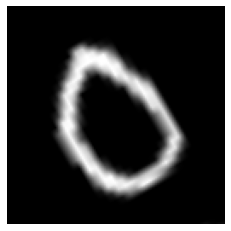

Prediction scores from the output layer(Without SoftMax):  [[11.644558   -7.1682987   2.8502371  -1.5525218  -3.784955    0.20252255
   4.8134694  -1.5057766   2.975349    6.587664  ]]
Predicted label: 0


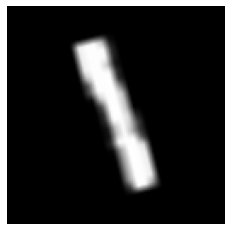

Prediction scores from the output layer(Without SoftMax):  [[-2.9619668   9.416132    2.5618122  -1.5543418  -0.11259276  1.4661502
   2.2255912   0.7563828   0.9710476  -0.7820186 ]]
Predicted label: 1


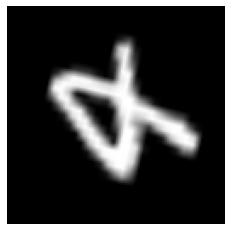

Prediction scores from the output layer(Without SoftMax):  [[-6.7633595 -3.1873775  7.072575  -3.9540274  8.459643   0.6480639
   1.9877342  2.4582145  5.097186   3.8703117]]
Predicted label: 4


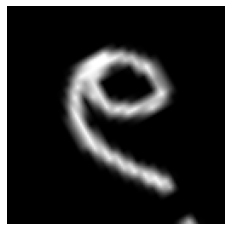

Prediction scores from the output layer(Without SoftMax):  [[ -1.4299823  -11.206424     3.16728     -1.2699347   -2.586813
    4.061634    13.207694     0.18999751   2.2399147    7.219979  ]]
Predicted label: 6


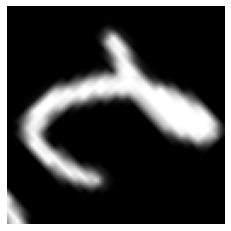

Prediction scores from the output layer(Without SoftMax):  [[-6.488024   1.0417142 12.850224   6.267281   7.584242   4.754543
  -4.3679147  7.8613563  4.00033    2.1677725]]
Predicted label: 2


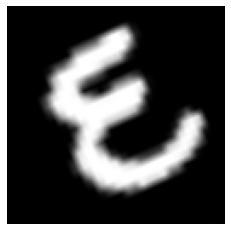

Prediction scores from the output layer(Without SoftMax):  [[-6.474179  -1.9308661  4.3527617 16.77062   -3.7555892  3.7947974
   1.7440654  6.198502  -3.6945202  2.4490855]]
Predicted label: 3


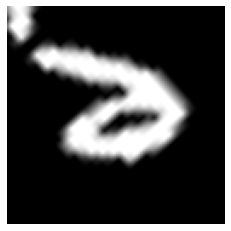

Prediction scores from the output layer(Without SoftMax):  [[ -3.485095   -14.67893      4.2097654    0.44446117   3.055256
    0.5826999    1.5145197    2.0431817   -0.41166228   9.4106045 ]]
Predicted label: 9


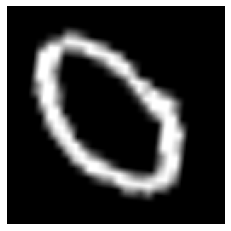

Prediction scores from the output layer(Without SoftMax):  [[14.310318  -9.042498   4.40806    3.2090988 -2.8499248  2.4437895
   3.3282595 -6.6073904  5.097263   5.1803317]]
Predicted label: 0


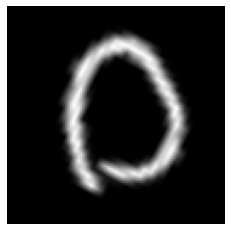

Prediction scores from the output layer(Without SoftMax):  [[10.782976   -5.4236016   3.7710812  -1.2088276  -1.6292899   0.27843913
   2.4683917   0.2675317  -0.6939499   6.992299  ]]
Predicted label: 0


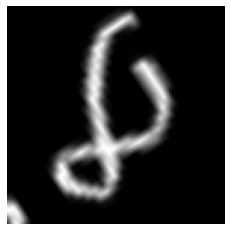

Prediction scores from the output layer(Without SoftMax):  [[-3.5269573 -2.40095    5.8347416  7.588638   2.8484614  2.0580058
  -2.445909   3.2673626  6.6431713  2.427356 ]]
Predicted label: 3


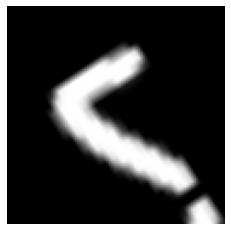

Prediction scores from the output layer(Without SoftMax):  [[-12.640273    -3.0313988    1.5534174   -0.20440227  -0.31088382
    1.0046353    2.0240254   10.559611    -0.09695131   2.4613037 ]]
Predicted label: 7


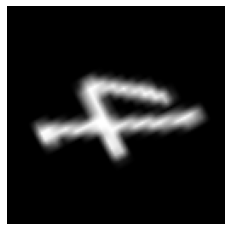

Prediction scores from the output layer(Without SoftMax):  [[-4.623697   -2.217163    1.2038808  -1.431167    6.8943615  -3.3212461
  -0.38288885  1.9504234   4.4142895   1.3381045 ]]
Predicted label: 4


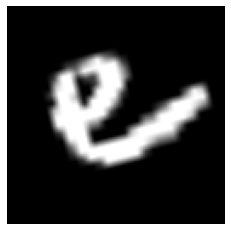

Prediction scores from the output layer(Without SoftMax):  [[-3.3458602  -8.726019    1.4731197  -0.07999879 -2.951437    2.184576
   9.76872     0.528053   -1.3632035   2.5945733 ]]
Predicted label: 6


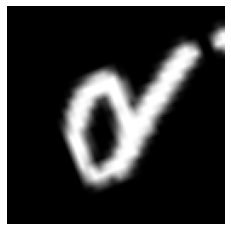

Prediction scores from the output layer(Without SoftMax):  [[-2.3413908 -8.840713   3.782347  -1.1688985  2.809999   0.9000157
   1.8870075  4.771983   2.334903  10.741437 ]]
Predicted label: 9


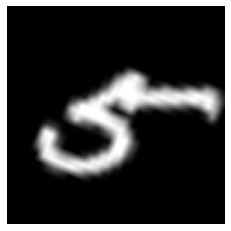

Prediction scores from the output layer(Without SoftMax):  [[-3.7352743  -6.696425    4.3194513   4.2680736   0.9595186   9.232929
   2.7859757  -0.63409835  5.270605    5.080926  ]]
Predicted label: 5


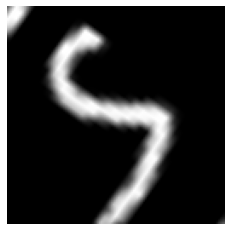

Prediction scores from the output layer(Without SoftMax):  [[-8.594169  -3.7239451 11.509285   1.8793362 -1.6503564  9.1542425
   4.196346  -2.8801     4.772938   4.5904317]]
Predicted label: 2


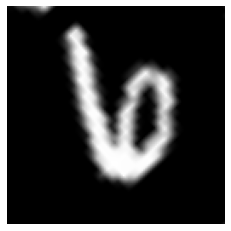

Prediction scores from the output layer(Without SoftMax):  [[-4.6569724e+00 -1.4010262e+01  3.2714550e+00 -4.6846614e+00
  -5.4527860e+00  2.2598455e+00  1.4607982e+01  4.0895694e-01
  -6.5581277e-03  8.0585957e+00]]
Predicted label: 6


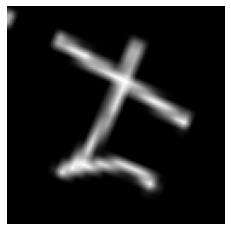

Prediction scores from the output layer(Without SoftMax):  [[-16.864428     4.993337     8.949813    -3.575627    13.821382
    0.48621777  -3.6907501    7.1455927    2.274299    -1.5673501 ]]
Predicted label: 4


In [ ]:
loss, acc = model.evaluate(real_life_data)
print("Accuracy", acc)

X, y = next(iter(real_life_data))
show_image_prediction(X, y)

## Explain why re-training the model with new augmented dataset helped improve the acuracy of the model?


In [ ]:
# Question 4: Summarize your learning in 2 sentences (1 Point)

# Write your answer here

###Answer is  here###
'''
Our previous datasets before augmentaion was quite pristine. That's why we had an accuracy of 98%.
But, we use augmented data i.e. flipped('horizontal and vertical') and scaled data , accuracy of our previous model was not good for new augmented data.
After re-training the model with augmented data produced better results because previous model could not recognize the changed orientation of the input.
We also use data augmentation to increase the diversity of data available for training models, without actually collecting new data.

'''

## Transfer Learning

Transfer learning involves taking a pre-trained neural network and adapting the neural network to a new, different data set with different task. In general, a Deep Learning model requires a lot of training data to acheive a good accuraccy. But there could be case where a large amount of training data is very scarce. In those cases, Transfer Learning comes in handy.

While there are different Transfer Learning method based on the similarity and dataset size of the down task, I would like to show you one particular case:  

**New data set is small, new data is similar to original training data.**
In this case we are going to freeze the weight update of the original model, and only updating the weights of the classification layer is sufficcient. Example to be shown in the following cell.

But if the new data is not similar with the previously trained data, the technique we use to solve this issue is called Fine Tuning, where we do not freeze the weight update of the original model.


In the following section we are going to use a pre-trained model called **Xception** trained on **ImageNet** dataset. Our goal is to train a relatively smaller dataset of flowers. A pre-trained model is a type of model which is already trained on a large dataset and could be used as a feature extractor for the classification layer. Classification layer means the Dense/Linear layer that we typically use in a neural network. This feature extractor can learn meaningful features from a image. In this example the weights of the feature extractor will be frozen.  However, the final, classification layer of our model will be specific to the original flower classification task.

![alt text](https://miro.medium.com/max/1400/1*qfQ3hmHLwApXZBN-A85r8g.png "Transfer Learning")

Image courtesy and for a more detailed understanding of Transfer Learning please read [Medium](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)




Consider the image above. In the left hand side, we have a model(in our case **Xception**) which is trained on a large dataset(**ImageNet**). Then we tear-up/remove the classification layers(Green Layers) and attach remaining CNN layers(Green Layer) with a different classifier(Green Layer) on the Right hand side. Then we can freeze the CNN layer(Blue Layer) and train the Classifier Layer. Otherwise we can fine tune the CNN layers along with the classifiers without freezing the model which is also known as Fine-Tuning.




## Loading Dataset

For this task, we will use *tf_flowers* dataset and call our previously defined *prepare* function to get train, test and validation batches. Then we will find the number of classes and a function  to convert the numbered labels to string labels.


In [ ]:
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

flower_train_ds = data_augment(train_ds, shuffle=True, augment=True)
flower_val_ds = data_augment(val_ds, shuffle=True, augment=True)
flower_test_ds = data_augment(test_ds, shuffle=True, augment=True)

num_classes = metadata.features['label'].num_classes
print("Number of classes we want to classify", num_classes)
get_label_name = metadata.features['label'].int2str
print(len(flower_train_ds))
print(len(flower_val_ds))
print(len(flower_test_ds))

Number of classes we want to classify 5
92
12
12


Then we are going to load Xception model which is trained on ImageNet Dataset and freeze this layer

In [ ]:
# (128, 128, 3) is the shape of the input images
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False)

# Freeze base model
base_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Complete the model

Initial part to add the base model and GlobalAveragePooling2D is done for you. Complete the rest of the Dense layer, and rest of the parts according to the instruction. Also see how fast we were able to train our model compared to the previous ones.

In [ ]:
import numpy as np
image_batch, label_batch = next(iter(flower_train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.summary()
#model = Sequential()
#model.add(base_model)
#model.add(tf.keras.layers.GlobalAveragePooling2D())

# Question 5: Write the code to construct the Dense layer for the model (1 point)

#Write your code here

#model.add(Dense(128, activation='relu'))
#model.add(Dense(num_classes))
#model.add(GlobalAveragePooling2D())


# Learning Rate
base_learning_rate = 0.001
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(128, 128, 3))
#x = data_augment(inputs, shuffle=True, augment=True)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Question 6: Compile the model (1 point)
'''model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Number of Epochs
epochs=100
#model.summary()
#print(flower_train_ds.shape)
#X_train = list(map(lambda x: x[0], flower_train_ds))
#X_train.pop()
#X_train.pop()
#X_train_add = X_train[84:92]
#X_train.append(X_train_add)
#X_train = X_train.reshape((-1,5))
#train_arr =np.array(X_train)
#print(train_arr.shape)
#train_arr = train_arr.reshape((-1,5))
#print(len(X_train))
#flower_train_ds = np.asarray(flower_train_ds).astype('float32').reshape((-1,1))
# Question 7: Train and Evaluate the model and show the accuracy (1 point)
#history = model.fit(flower_train_ds,
#                    epochs=epochs)
# Write your code here
history = model.fit(flower_train_ds,
                    epochs=epochs,
                    validation_data=flower_val_ds)


(32, 4, 4, 2048)
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                          

## Try out the model on an image from the outside data

This section is for learning pusposes only. Outside data means, data that the model has never seen and compared to random real life data.

2


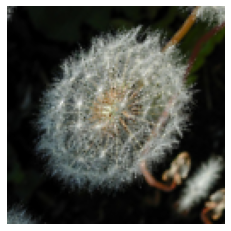

Prediction scores from the output layer(Without SoftMax):  [[ 0.10361531 -0.4415868  -0.17767519 -0.33341336 -0.24896577]]
Predicted label: dandelion


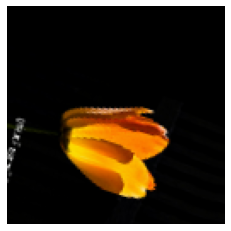

Prediction scores from the output layer(Without SoftMax):  [[ 0.39284003 -0.19290687 -0.26316345 -0.50092566 -0.3079633 ]]
Predicted label: dandelion


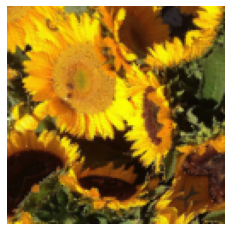

Prediction scores from the output layer(Without SoftMax):  [[-0.4635919  -0.5360292   0.12148094  0.49742663 -0.41804647]]
Predicted label: sunflowers


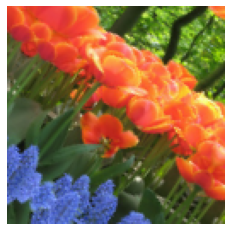

Prediction scores from the output layer(Without SoftMax):  [[ 0.28534418 -0.7496842  -0.15799272  0.00987712 -0.29725328]]
Predicted label: dandelion


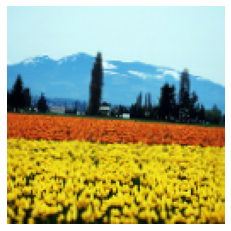

Prediction scores from the output layer(Without SoftMax):  [[-0.2944619  -0.5011866   0.15537867 -0.1989268  -0.29220897]]
Predicted label: tulips


In [ ]:
# Extract a single image from the Validation Dataset. 
# X is the image matrices and y is the labels(int value)
print(len(model.trainable_variables))
X, y = next(iter(flower_val_ds))

# Showing 6 random image
show_image_prediction(X[:5], y[:5])


In [ ]:
# Question 8: Summarize your learning in 2 sentence (1 Point)

# Write your answer here
'''
Answer:: Transfer learning is basically using another model trained via different datasets .
here, we have used Xception model which was trained using Imagenet datasets. We used Xception model as a base model and added dense layers as per our
requirements. We used a different datasets (tf_flowers) for our model. We showed that our accuracy can be higher with adequate training and good learning rate. We trained
our model for 100 epochs to see whether we are having better accuracy with the increase of training.

For transfer learning, I guess similar datasets for experiments will produce better results. 
'''